# State Prison Infection Rates over Time
This notebook uses the Marshall Project's data to visualize covid infection rates in prisons across the US.
Scroll to the bottom of the notebook for the map.

Geopandas handles geographic data. Folium is for creating the dynamic map.

In [1]:
import os
import geopandas as gpd
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from branca.colormap import linear
import folium
from folium.plugins import TimeSliderChoropleth

### Import the map overlay data
The geographic `json` data for the United States' boundaries is cached in this repo.

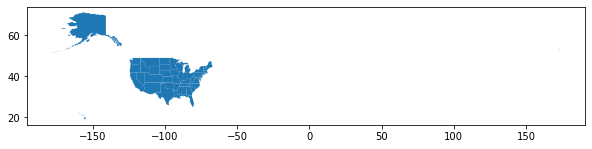

In [3]:
datapath = 'us-states.json'
gdf = gpd.read_file(datapath)
%matplotlib inline
ax = gdf.plot(figsize=(10,10))

Definitely the right country. I'd like to bring Alaska and Hawaii in though so that I can see everything up close.

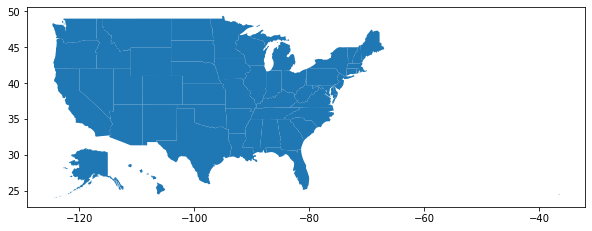

In [4]:
mask = gdf.id == "HI"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(1.3,1.3).translate(49,6))
mask = gdf.id == "AK"
gdf[mask] = gdf[mask].set_geometry(gdf[mask].scale(.25,.35).translate(-78,-34))
ax = gdf.plot(figsize=(10,10))

# Prep

### Import state prison covid counts

Download the latest Marshall Project data.

In [6]:
def fetch(filename):
    # make request
    template_url="https://raw.githubusercontent.com/themarshallproject/COVID_prison_data/master/data/{}"
    resp = requests.get(template_url.format(filename))

    # save file
    with open(filename, 'wb') as f:
        f.write(resp.content)

In [7]:
fetch("covid_prison_cases.csv")
fetch("prison_populations.csv")

And import it.

In [8]:
cases = pd.read_csv("covid_prison_cases.csv")

In [9]:
cases.head()

,name,abbreviation,staff_tests,staff_tests_with_multiples,total_staff_cases,staff_recovered,total_staff_deaths,prisoner_tests,prisoner_tests_with_multiples,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths,as_of_date,notes
0,Alabama,AL,NaN,NaN,907.0,774.0,3.0,NaN,14552.0,1294.0,1138.0,57.0,01/18/2021,NaN
1,Alaska,AK,NaN,NaN,256.0,NaN,0.0,NaN,19213.0,2269.0,NaN,5.0,01/19/2021,They are vaccinating but not tracking numbers.
2,Arizona,AZ,NaN,NaN,2254.0,1775.0,NaN,43396.0,NaN,8778.0,7138.0,45.0,01/19/2021,NaN
3,Arkansas,AR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10877.0,10720.0,52.0,01/19/2021,NaN
4,California,CA,NaN,NaN,14560.0,12421.0,19.0,116167.0,NaN,45486.0,40696.0,175.0,01/19/2021,NaN


### Subset
To just the rows with collection date and case count info. Exclude rows for the federal count.

In [10]:
cases = cases[cases['as_of_date'].notnull()]
cases = cases[cases['total_prisoner_cases'].notnull()]
cases = cases[cases['name'] != "Federal"]

Note that we have data for each state (only the first five shown here).

In [11]:
cases[['name','total_prisoner_cases','as_of_date']].head()

,name,total_prisoner_cases,as_of_date
0,Alabama,1294.0,01/18/2021
1,Alaska,2269.0,01/19/2021
2,Arizona,8778.0,01/19/2021
3,Arkansas,10877.0,01/19/2021
4,California,45486.0,01/19/2021


And for each state, we have data for many different points in time.

In [12]:
cases[['name','total_prisoner_cases','as_of_date']][cases['name']=='Tennessee'].head()

,name,total_prisoner_cases,as_of_date
41,Tennessee,6439.0,01/19/2021
92,Tennessee,6392.0,01/12/2021
143,Tennessee,6353.0,01/05/2021
194,Tennessee,6211.0,12/29/2020
245,Tennessee,6194.0,12/22/2020


### Gather and Organize
Create a new dataframe from `cases`. It needs to have states in alphabetical order as the rownames, collection dates as the column names, and current prisoner cases as the values.

In [13]:
# Pull out a list of the states
states = cases["name"].unique()
states.sort() # alphabetized

In [14]:
# Pull out a list of the dates
collection_dates = cases['as_of_date'].unique()
sorted_dates = sorted(collection_dates, key=lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [15]:
# Create an empty dataframe with rows indexed by the alphabetical states
df = pd.DataFrame(index=states)

In [16]:
# Load that dataframe with the case values corresponding to each state and collection date.
for date in sorted_dates:
    names_cases = cases[cases['as_of_date']==date][['name','total_prisoner_cases']]
    df = pd.merge(df, names_cases, how='left', left_on=df.index, right_on="name")
    df.index = df['name']
    df.drop("name", axis=1, inplace=True)
    df.rename(columns={'total_prisoner_cases':date}, inplace = True)

The empty (`NaN`) values in this dataframe result from states submitting their data on different days.

For instance, you can see below that Alabama is the only one of these five states with a case count for the date `03/31/2020`. This means Alabama submitted data on that day, but none of those other four states did. On the next day, however, we hear from the other four states. 

If a state didn't report a case count on a given day, we will use their last reported count.

In [17]:
df.head()

,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/31/2020,04/01/2020,04/02/2020,04/03/2020,04/06/2020,04/07/2020,...,01/11/2021,01/12/2021,01/13/2021,01/14/2021,01/15/2021,01/18/2021,01/19/2021,01/20/2021,01/21/2021,01/22/2021
name,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,1262.0,NaN,NaN,NaN,1294.0,NaN,NaN,NaN,NaN
Alaska,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,2222.0,NaN,NaN,NaN,NaN,2269.0,NaN,NaN,NaN
Arizona,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,8042.0,NaN,NaN,NaN,NaN,8778.0,NaN,NaN,NaN
Arkansas,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,10832.0,NaN,NaN,NaN,NaN,10877.0,NaN,NaN,NaN
California,NaN,NaN,1.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,44079.0,NaN,NaN,NaN,NaN,45486.0,NaN,NaN,NaN


### Calculate Infection Rate

Visualizing absolute case numbers would show California and Texas having particularly bad outcomes compared to other states, but this is largely due to their having higher prisoner populations. To be able to compare from one state to the next, we'll calculate a rate of infection based on prison population numbers and covid case counts.

Since populations were reported fewer (and at different) times than case numbers were, we'll estimate population at each covid case report date via interpolation.

In [18]:
# Read in the population data
raw_pop = pd.read_csv("prison_populations.csv")

In [19]:
raw_pop = raw_pop.set_index('name')
raw_pop.drop(index="Federal", inplace=True) # Ditch the federal data
raw_pop.tail()

,abbreviation,march_pop,april_pop,june_pop,july_pop,aug_pop,sept_pop,oct_pop,nov_pop,as_of_date_march,as_of_date_april,as_of_date_june,as_of_date_july,as_of_date_aug,as_of_date_sept,as_of_date_oct,as_of_date_nov
name,,,,,,,,,,,,,,,,,
Virginia,VA,29161,28559,28595,26749,26190,25659,25156,24731,03/13/2020,04/14/2020,06/16/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020,11/30/2020
Washington,WA,17263,16906,15837,15626,15494,15339,15198,15111,03/31/2020,04/30/2020,06/30/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020,11/30/2020
West Virginia,WV,5952,5556,4898,4398,4331,4275,4247,4189,03/15/2020,04/15/2020,06/15/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020,11/30/2020
Wisconsin,WI,23591,22507,21576,21252,21136,21495,20796,20494,03/13/2020,04/17/2020,06/12/2020,07/31/2020,09/04/2020,10/02/2020,10/30/2020,11/27/2020
Wyoming,WY,2156,2098,2001,1986,1959,1996,2232,2157,03/15/2020,04/15/2020,06/16/2020,07/31/2020,08/31/2020,09/30/2020,10/31/2020,11/30/2020


In [20]:
# Extract the report dates.
dates = raw_pop.loc[:, "as_of_date_march":"as_of_date_oct"].T
dates = dates.astype('datetime64')

In [21]:
# Extract the population reports.
pops = raw_pop.loc[:, "march_pop":"oct_pop"].T

In [22]:
# Create an empty DF to fill in. Each column is a state. Indexed by DateTimeIndex.
full_date_range = pd.to_datetime(pd.date_range(dates.min().min(), dates.max().max()))
full_dates = pd.DataFrame(columns=pops.columns, index=full_date_range, dtype=int)

In [23]:
# Sparsely fill in our population data where we have it.
for state in full_dates.columns:
    x = dates[state]
    y = pops[state]
    full_dates[state][x] = list(y) # list(y) so that items aren't joined by index

In [24]:
# Fill population values by interpolating. limit_direction='both' ensures we extrapolate the data
# past the last sample (eg all the way from min date to max date)
full_dates = full_dates.interpolate(method='time', limit_direction='both')

We use this dataframe to estimate the population of a state's prison system on any day within the range.

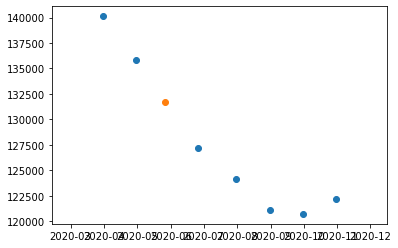

In [25]:
# Query
state = "Texas"
day = "05/27/2020"

# Known data
x = dates[state]
y = pops[state]

# Estimated data
x_est = pd.to_datetime(day)
y_est = full_dates[state][day]

# Plot
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.scatter(x_est, y_est)

#Blue dots are known population counts. The orange dot is the estimated population at that date.

Now that we have a way to estimate population, we can get infection rates.

Subset case count dataframe to dates for which we can interpolate population. Even though we have more recent counts of case numbers, most prisons stopped reporting their overall population counts earlier, so these later case counts don't help us.

In [26]:
dates_to_keep = pd.to_datetime(df.columns).isin(full_date_range)
df = df.loc[:,dates_to_keep]

Replace infection *count* data with infection *rate* data.

In [27]:
for state in df.index:
    
    case_counts = df.loc[state]
    count_dates = pd.to_datetime(df.loc[state].index.values)
    
    all_pops = full_dates[state]
    pop_date = all_pops.index
    
    pops = all_pops[pop_date.isin(count_dates)]
    
    df.loc[state] = case_counts / pops * 100

In [28]:
# Change state name index to a numerical index (Alabama = 0, Wyoming = 49).
df_statenames = df.copy() # Save for later
df.index = np.arange(0,50)

### Create Index
Create a `DatetimeIndex` instance of the collection dates. This is necessary for use within Folium.

In [29]:
dt_index = pd.to_datetime(df.columns).astype(int).astype("U10")

### Create overlay
The Folium plugin for the choropleth map with a time slider takes two arguments:
1. A `geopandas` dataframe (converted to json)
2. The dictionary describing how to style the map overlay

We've already made the first thing. Now, we'll construct the second.

In [30]:
styledata = {}

for state in gdf.index:
    style_df = pd.DataFrame(
        {
            "color": np.array(df[df.index==state])[0], # rates over time for that state
            "opacity": np.ones(len(df.columns))#*0.75
        },
        index=dt_index,
    )
    style_df["color"].fillna(method="pad", inplace=True)
    style_df["color"].fillna(0, inplace=True)
    assert all(pd.notnull(style_df["color"]))
    styledata[state] = style_df

Now the map and the data are linked through the index running from `0` to `49`.

In [31]:
# Arkansas' geographical info
gdf.loc[3]

id                                                         AR
name                                                 Arkansas
geometry    POLYGON ((-94.473842 36.501861, -90.152536 36....
Name: 3, dtype: object

In [32]:
# Arkansas' infection data
styledata.get(3).tail()

,color,opacity
1604188800,50.505118,1.0
1604275200,50.505118,1.0
1604361600,52.543170,1.0
1604448000,52.543170,1.0
1604534400,52.543170,1.0


The value of the color at each timestamp represents the percent of prisoners in that state who have covid.
The opacity is fixed at 1.

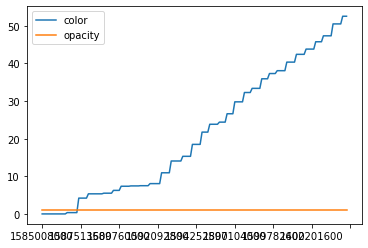

In [33]:
ax = styledata.get(3).plot()

We'll need to include the worst rate data in the geodataframe (for the tooltip which we'll add later):

In [34]:
worst_rate = []
for state in range(0,50):
    worst = max(styledata.get(state)['color'])
    worst = str(round(worst,1)) + "%"
    worst_rate.append(worst)

gdf['worst_rate'] = worst_rate
gdf.head()

,id,name,geometry,worst_rate
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",3.9%
1,AK,Alaska,"MULTIPOLYGON (((-112.70742 25.25471, -112.6992...",5.2%
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",6.8%
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",52.5%
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",17.0%


Now, we represent each color value as a hex color.

In [35]:
max_color = 0

for _, data in styledata.items():
    max_color = max(data["color"].max(), max_color)
    min_color = 0 # A universal minimum allows us to compare one state's color to another.

Define and apply color maps: 

In [36]:
cmap = linear.YlOrRd_09.scale(min_color, max_color)
for _, data in styledata.items():
    data["color"] = data["color"].apply(cmap)

In [37]:
styledata.get(0).head()

,color,opacity
1585008000,#ffffccff,1.0
1585094400,#ffffccff,1.0
1585180800,#ffffccff,1.0
1585267200,#ffffccff,1.0
1585612800,#ffffccff,1.0


Next, we convert each dataframe into a dictionary for use within Folium.

In [38]:
styledict = {
    str(state): data.to_dict(orient="index") for state, data in styledata.items()
}

Finally, we build the basemap and the overlay.

In [39]:
# The Overlay we care about
g = TimeSliderChoropleth(
    data=gdf.to_json(),
    styledict=styledict,
)

In [40]:
# Use an empty basemap to only show the overlay
m = folium.Map(location=[35,-96],
                zoom_start=4,
                tiles=None,
                zoom_control=False
               )

In [41]:
g.add_to(m)

Adding a legend will require a bit of a hack.

If this were a static choropleth overlay, a legend would come along for free. Since it isn't, we'll have to create a second overlay as a `folium.Choropleth` instance to get a legend. Then we'll set this new overlay's opacity to zero, leaving only its legend visible.

In [42]:
df_dict = {"name" : list(df_statenames.index),
           "counts_range" : max_color}

In [43]:
legend_df = pd.DataFrame(df_dict)
legend_df.iloc[0,1] = min_color

In [44]:
leg = folium.Choropleth(
    geo_data=gdf,
    bins=9,
    name="choropleth",
    data=legend_df,
    columns =['name','counts_range'],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0,
    line_opacity=1,
    legend_name="% of State Prisoners with Covid-19",
    smooth_factor=0.95,
    highlight=True,
)

Add the mouseover tooltip displaying each state's worst rate on the record.

In [45]:
style_options = 'background-color: black; color: white; font-family: "Pressura", monospace; font-weight: 900; font-size: 12px; padding: 5px'

tt = folium.features.GeoJsonTooltip(fields=["name", "worst_rate"],
                                    aliases=["", "Worst Day on Record:"],
                                    sticky=True,
                                    style=style_options)
tt.add_to(leg.geojson)

In [46]:
leg.add_to(m)
m

Make sure to view the notebook through nbviewer so that the map renders properly. 

The below document is for the visualization in GitHub Pages.

In [47]:
m.save("rates.html")